# Introduction

How expensive is to go for holiday to Berlin ? Let's figure it out !

Please find comprehensive analysis of trends present in the data and following them predictions.

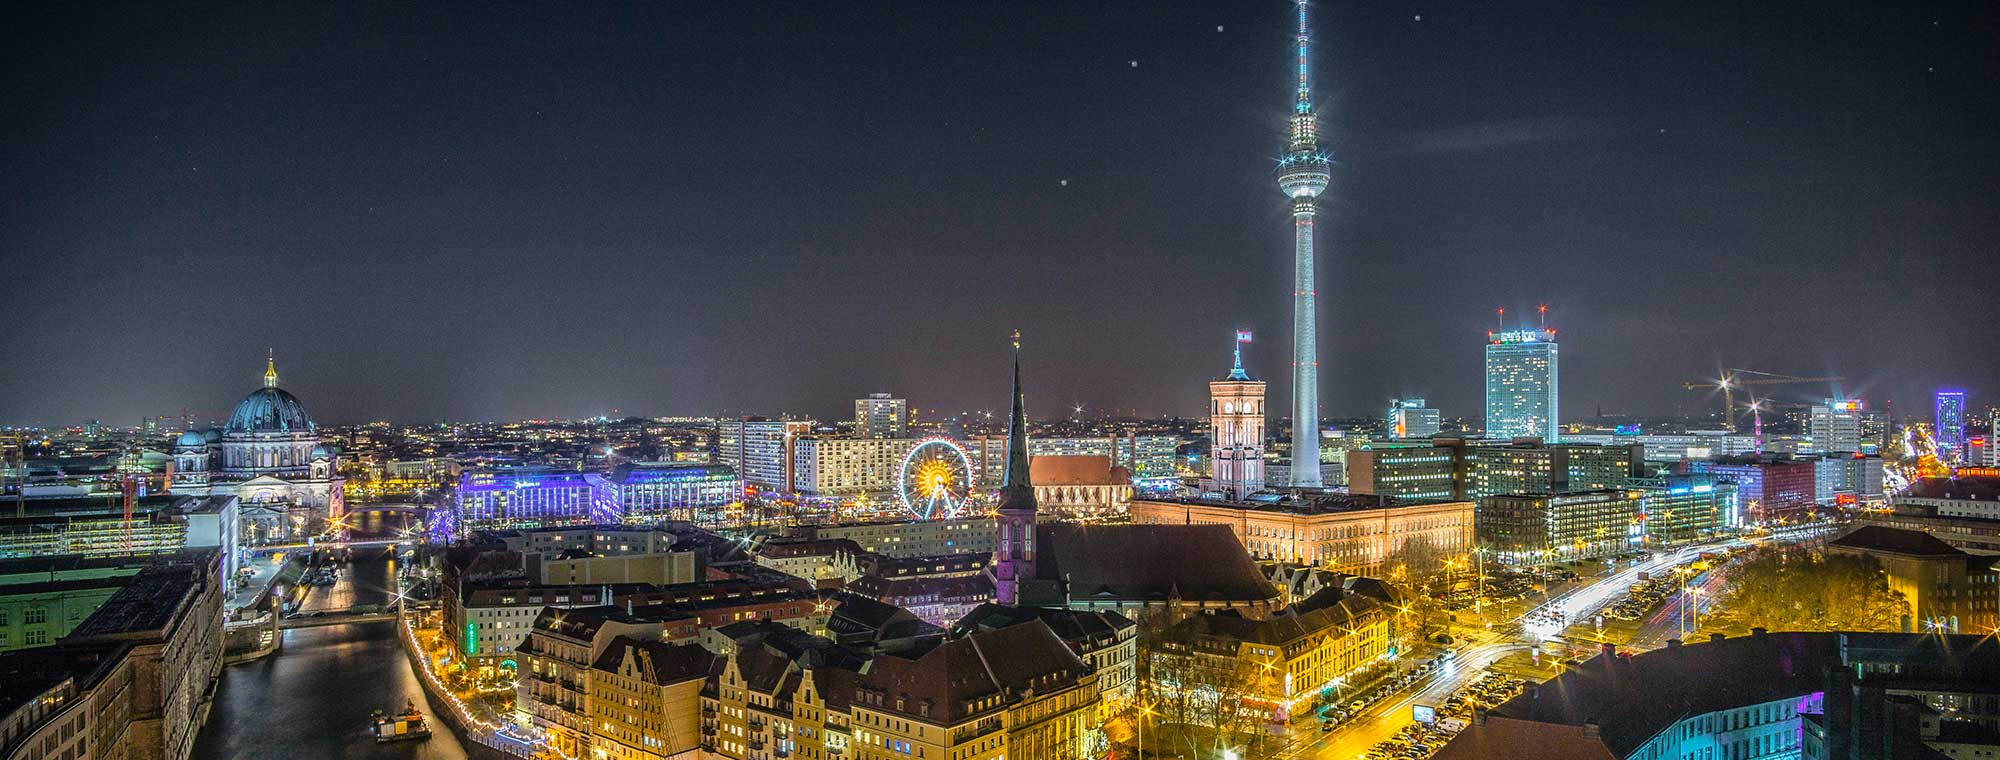

The main goal of this analysis is to understand the data and predict the rent price for given AirBnB 
flats in Berlin's area. The analysis was divided in the 5 parts.

First, I started from the data cleaning. Namely, the relevant factors were identified and modified
for this investigation. As the purpose of the analysis was to understand factors applying set of
basic unsupervised methods, I resigned from the interesting variables containing longer pieces of
text like "Summary" or "Review". Next, I define couple of functions for banding and ordering
factors. All prices variables are transformed from string to numeric and included in the analysis.
The response for the analysis is variable "price".

Next stage is data analysis started with one way analysis of both numeric and categorical factors.
Data is then cleaned, scaled and transformed into dummy values for the further use. Following this
step, correlogram is applied for all numeric variables. Next, all categorical variables are analyzed
by use of hit rates bar plots. For the numeric ones, I employ Receiver Operation Characteristic.
Following this point, I apply Principal Component Analysis and choose proper number of PC's.
Alternatively, I investigate k-means clustering by use of Lloyd's algorithm. For the brief check
also Gaussian mixture is applied but due to long fitting, only for latitude and longitude.
Forth part is based on the employment of regular linear models. The first, I define mean of prices
as a benchmark. First model applied is linear regression for both numeric and dummy variables.
Second one is generalized linear model with Poisson error distribution. The last one is least
absolute shrinkage and selection operator (LASSO) as only selection algorithm. Additionally, I
compare it also with Ridge and elastic net.

The second group of models are structures classified as machine learning methods. Firstly, the
simplest - random tree. Next random forest with elementary validation. The last one is powerful
algorithm called gradient boosting.

The last part is comparative analysis. It contains two chapters. First one is investigation of
model error. It is done on the basis of Mean absolute error and alternatively more popular Root
mean squared error. The second part is actual vs expected analysis to identify graphically models
performance. Eventually the results of models' performance is presented.

LIBRARIES

In [ ]:
# Clear variables
rm(list=ls())

message=FALSE 
warning=FALSE
  
# Load libraries and functions
library(tidyverse) 
 install.packages("geodist")
 install.packages("AUC")
  library(ggplot2)
  library(corrplot)
  library(AUC)
  library(gtools)
  library(cluster)
  library(glmnet)
  library(fastDummies)
  library(xgboost)
  library(randomForest)
  library(rpart)
  library(rpart.plot)
  library(geodist)
  library(zoo)

list.files(path = "../input")

options(warn=-1)

'%nin%' = Negate('%in%')

DATA LOAD

In [ ]:
# Load data
  data_raw <- read.csv('../input/berlin-airbnb-data/listings_summary.csv')
  
  #We delete variables which are expected to be useful only for networks
  drop <- c("listing_url","scrape_id","last_scraped","thumbnail_url","medium_url","picture_url","xl_picture_url","host_url","host_thumbnail_url","host_picture_url","calendar_last_scraped","name","description","summary","space","neighborhood_overview","experiences_offered","experiences_offered","notes","transit","access","interaction","house_rules","host_about")
  data <- data_raw[,!(names(data_raw) %in% drop)]
  
  # Determine variable names for numeric and factor types (leave out url variables)
  namesVar <- names(data) %>% .[. %nin% c("id","host_id")]
  isNum    <- sapply(data, is.numeric) 
  namesNum <- colnames(data)[isNum] %>% .[. %nin% c("id","host_id")]
  namesNumNoPrice <- colnames(data)[isNum] %>% .[. %nin% c("id","host_id","price","security_deposit","cleaning_fee","extra_people")]
  isFac    <- sapply(data, is.factor) 
  namesFac <- colnames(data)[isFac] %>% .[. %nin% c("id","host_id")]
  
  # Fixed seed for reproducability
  #set.seed(123456)

In [ ]:
  #Geographical
  nameGeo <- c("latitude","longitude")
  onlyReviews <- c("review_scores_accuracy","review_scores_value","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_rating","review_scores_location")
  
  #Define the center of the city
  Berlin_centre_lon<-rep(13.4041667)
  Berlin_centre_lat<-rep(52.5027778)
  Berlin_centre_location <- cbind(Berlin_centre_lon, Berlin_centre_lat)

In [ ]:
#Interesting functions (differnt authors)

km.fromscratch <- function(X, k){
  p <- ncol(X)  # number of parameters
  n <- nrow(X)  # number of observations
  Delta <- 1; iter <- 0; itermax <- 30
  while(Delta > 1e-4 && iter <= itermax){
    # initiation
    if(iter == 0){
      centroid <- X[sample(nrow(X), k),]
      centroid_mem <- centroid
    }
    
    # equivalent to E-step
    d <- sapply(1:k, function(c) sapply(1:n, 
      function(i) sum((centroid[c,] - X[i,])^2) ))
    cluster <- apply(d, 1, which.min)
    
    # equivalent to M-step
    centroid <- t(sapply(1:k, function(c) 
      apply(X[cluster == c,], 2, mean)))
    
    Delta <- sum((centroid - centroid_mem)^2)
    iter <- iter + 1; centroid_mem <- centroid
  }
  return(list(centroid = centroid, cluster = cluster))
}

gmm.fromscratch <- function(X, k){
  p <- ncol(X)  # number of parameters
  n <- nrow(X)  # number of observations
  Delta <- 1; iter <- 0; itermax <- 30
  while(Delta > 1e-4 && iter <= itermax){
    # initiation
    if(iter == 0){
      km.init <- km.fromscratch(X, k)
      mu <- km.init$centroid; mu_mem <- mu
      w <- sapply(1:k, function(i) length(which(km.init$cluster == i)))
      w <- w/sum(w)
      cov <- array(dim = c(p, p, k))
      for(i in 1:p) for(j in 1:p) for(c in 1:k) cov[i, j, c] <- 
        1/n * sum((X[km.init$cluster == c, i] - mu[c, i]) *
        (X[km.init$cluster == c, j] - mu[c, j]))
    }
    
    # E-step
    mvn.c <- sapply(1:k, function(c) mvn.pdf(X, mu[c,], cov[,, c]))
    r_ic <- t(w*t(mvn.c)) / rowSums(t(w*t(mvn.c)))
    
    # M-step
    n_c <- colSums(r_ic)
    w <- n_c/sum(n_c)
    mu <- t(sapply(1:k, function(c) 1/n_c[c] * colSums(r_ic[, c] *
      X)))
    for(i in 1:p) for(j in 1:p) for(c in 1:k) cov[i, j, c] <-
      1/n_c[c] * sum(r_ic[, c] * (X[, i] - mu[c, i]) * r_ic[, c] *
      (X[, j] - mu[c, j]))
    Delta <- sum((mu - mu_mem)^2)
    iter <- iter + 1; mu_mem <- mu
  }
  return(list(softcluster = r_ic, cluster = apply(r_ic, 1,
    which.max)))
}

  #Banding function
  Banding <- function(variable, n) {
    temp <- aggregate(data$dummy, by=list(Category=data[[variable]]), FUN=sum)
      temp$rate <- temp$x/ sum(temp$x)
        result <- temp[temp$rate < n,]
        return(as.factor(ifelse(as.character(data[[variable]]) %in% as.character(result$Category), "OTHER", as.character(data[[variable]]))))
  }
  
  TimeFrom <- function(variable){
    return((as.yearmon(strptime("2020-02-11", format = "%Y-%m-%d"))-as.yearmon(strptime(data[[variable]], format = "%Y-%m-%d"))) *12)
  }
  
  DistanceFrom <- function(longitude,latitude) {
    return(geodist(Berlin_centre_location,c(longitude,latitude)))
  }

# Data cleaning

The whole data set contains 22.552 observations, each of them is a one 
at from the AirBnB
data set for the city Berlin. Going through all the variables, I decide to drop factors containing
meaningful amount of text, since they can be used in satisfactory way only by use of sophisticated
neural network structures or alternative models. I list below all variables with their formats and
marking these one which were dropped before the main analysis.

In [ ]:
head(data)

In [ ]:
#Transform string values with currency sign to numeric values
data$price = as.numeric(gsub("\\$", "", data$price))
data$monthly_price = as.numeric(gsub("\\$", "", data$monthly_price))
data$weekly_price = as.numeric(gsub("\\$", "", data$weekly_price))
data$security_deposit = as.numeric(gsub("\\$", "", data$security_deposit))
data$cleaning_fee = as.numeric(gsub("\\$", "", data$cleaning_fee))
data$extra_people = as.numeric(gsub("\\$", "", data$extra_people))

data$dummy <- 1


  namesVar <- names(data) %>% .[. %nin% c("id","host_id")]
  isNum    <- sapply(data, is.numeric) 
  namesNum <- colnames(data)[isNum] %>% .[. %nin% c("id","host_id")]
  namesNumNoPrice <- colnames(data)[isNum] %>% .[. %nin% c("id","host_id","price","security_deposit","cleaning_fee","extra_people","monthly_price","weekly_price")]
  isFac    <- sapply(data, is.factor) 
  namesFac <- colnames(data)[isFac] %>% .[. %nin% c("id","host_id")]

   #Binary factor for "high/low price"
   price_shape <- quantile(data$price, na.rm=TRUE)
   data$price_high = 0
   data$price_high <- ifelse(!is.na(data$price) & data$price>200, 1, 0)

Unlock below if you want to see histograms for all variables:

In [ ]:
#for(nameVar in namesNumNoPrice){
#  barplot(table(data[,nameVar]), main="Histogram", ylab="Frequency", xlab=nameVar)
#}

#for(nameVar in namesFac){
#  barplot(table(data[,nameVar]), main=paste("Histogram for ", nameVar), ylab="Frequency",las=2)
#}

25 string variables are dropped and final data set contains 71 of them: 33 numeric and 38
categorical ones. Next I define three functions for data cleansing:
* Banding - it allows for banding application. Factors with too many numeric values are rounded and ordered
* TimeFrom - it transforms data from date format into convenient numeric format
* DistanceFrom - on the basis of longitude and latitude calculates the distance of the flat from the Berlin's centre

Applying summary of the data, I identify that a lot of numeric values contain errors and NA's.
Moreover, some of values which are supposed to be numeric, remain in string class due to the presence of percentage of dollar signs. Six variables: "price","monthly price","weekly price","security deposit","cleaning were transformed to the numeric format. As all these 6 factors can be considered as response, then
they will be removed from the list of numeric factors. Hence, only 27 numeric factors remain in use.

Next, I define additional response function for binary tests and call it as "price high". It is identified as price higher than 200.
Each variable is analyzed and the proper method is applied.

In [ ]:
data$distance_to_center <- geodist(x=cbind (data$longitude, data$latitude),y=Berlin_centre_location)
data$distance_to_center <- round(data$distance_to_center/100,0)*100

data[which(data[,"host_total_listings_count"]>10), "host_total_listings_count"] <- 10 #1. levels with no exposure grouped
#2."host_listings_count" to be dropped as alternative of the above one
data$latitude <- round(data$latitude,5)  #3.keep "latitude"
data$longitude <- round(data$longitude,5)  #4.keep "longitude"
#5.no changes for "accommodates"
data[which(data[,"bathrooms"]>3), "bathrooms"] <- 3
data[which(data[,"bathrooms"]<=0.5), "bathrooms"] <- 0.5 #6.levels with no exposure grouped
data[which(data[,"bedrooms"]>5), "bedrooms"] <- 5#	7	.levels with no exposure grouped
data[which(data[,"beds"]>10), "beds"] <- 10#	8	.levels with no exposure grouped
data$square_feet <- round(data$square_feet/1000,1)*1000 #	9	.band "square_feet"
data[which(data[,"guests_included"]>6), "guests_included"] <- 6 #	10	.levels with no exposure grouped.
#	11	.drop "minimum_nights"
#	12	.drop "maximum_nights"
data$availability_30 <- round(data$availability_30/10,1)*10 #	13	.keep "availability_30"
data$availability_60 <- round(data$availability_60/10,1)*10#	14	.keep "availability_60"
data$availability_90 <- round(data$availability_90/10,1)*10#	15	.keep "availability_90"
data$availability_365 <- round(data$availability_365/100,0)*100#	16	.keep "availability_365"
data[which(data[,"number_of_reviews"]>100), "number_of_reviews"] <- 100#	17	.levels with no exposure grouped.
data[which(data[,"review_scores_rating"]<75), "review_scores_rating"] <- 75#	18	.levels with no exposure grouped.
#	19	.not change "review" variables
#	20	.not change "review" variables
#	21	.not change "review" variables
#	22	.not change "review" variables
#	23	.not change "review" variables
#	24	.not change "review" variables
#	25	."calculated_host_listings_count" to be dropped as alternative of the first one
data$reviews_per_month <- round(data$reviews_per_month/10,1)*10 #	26	.keep "reviews_per_month"
#	27	.drop "host_name"
data$host_since<-TimeFrom("host_since")  #	28	.convert string variable into numeric months
#	29	.drop "host_location" as all hosts are from Berlin
levels(data$host_response_time)[levels(data$host_response_time)=="N/A"] <- "OTHER"
data$host_response_time <- Banding("host_response_time",0.01) #	30	.levels with no exposure grouped.
#	31	.drop "host_response_rate"
#	32	.drop "host_acceptance_rate", all exposure in one level
data$host_is_superhost <- Banding("host_is_superhost",0.01)#	33	.keep "host_is_superhost"
#	34	.drop "host_neighbourhood"
#	35	.drop "host_verifications"
#	36	.drop "host_has_profile_pic", all exposure in one level
data$host_identity_verified <- Banding("host_identity_verified",0.01) #	37	.keep "host_identity_verified"
#	38	.drop "street", all exposure in one level
data$neighbourhood <- Banding("neighbourhood",0.001)  #	39	.keep "neighbourhoud"
data$neighbourhood_cleansed <- Banding("neighbourhood_cleansed",0.001) #	40	.keep "neighbourhoud_cleansed
data$neighbourhood_group_cleansed <- Banding("neighbourhood_group_cleansed",0.001) #	41	.keep "neighbourhoud_group_cleansed
#	42	.drop "city", all exposure in one level
#	43	.drop "state", all exposure in one level
#	44	.drop "zipcode" temporarily to reduce exponentially nuber of dummies
#	45	.drop "market", all exposure in one level
#	46	.drop "smart_location", all exposure in one level
#	47	.drop "country_code", all exposure in one level
#	48	.drop "country", all exposure in one level
#	49	.keep "location_exact"
data$property_type <- Banding("property_type",0.01) #	50	.keep "property_type", almost everything in one level, but maybe certain type of property will have an impact on highest prices 
#	51	.keep "room_type"
#	52	.keep "bed_type"
data$amenities <- Banding("amenities",0.01) #	53	.keep "amenities"
data$calendar_updated <- Banding("calendar_updated",0.01) #	54	.keep "calendar_updated"
#	55	.drop "has_availability", all exposure in one level
#	56	.drop "first_review", messy alternative of "host_since"
#	57	.drop "last_review", messy alternative of "host_since"
#	58	.drop "requires_license", all exposure in one level
#	59	.drop "license"
#	60	.keep "instant_bookable"
#	61	.drop "is_business_travel_ready", all exposure in one level
#	62	.keep "cancellation_policy"
#	63	.drop "require_guest_profile picture", all exposure in one level
#	64	.drop "require_guest_phone_verification", all exposure in one level

  drop_cleansing <- c("host_listings_count","minimum_nights","maximum_nights","calculatred_host_listings_count","host_name","host_location","host_response_rate","host_acceptance_rate","host_has_profile_pic","street","city","state","market","smart_location","country_code","country","has_availability","first_review","last_review","requires_license","license","is_business_travel_ready","is_business_travel_ready","require_guest_phone_verification","require_guest_profile picture","host_neighbourhood","host_verifications","amenities","jurisdiction_names","neighbourhood","neighbourhood_cleansed","zipcode")
  data <- data[,!(names(data) %in% drop_cleansing)]
  
  #Redeinition
  namesVar <- names(data) %>% .[. %nin% c("id","host_id","dummy")]
  isNum    <- sapply(data, is.numeric) 
  namesNum <- colnames(data)[isNum] %>% .[. %nin% c("id","host_id","dummy")]
  namesNumNoPrice <- colnames(data)[isNum] %>% .[. %nin% c("id","host_id","price","security_deposit","cleaning_fee","extra_people","monthly_price","weekly_price","price_high","dummy")]
  isFac    <- sapply(data, is.factor) 
  namesFac <- colnames(data)[isFac] %>% .[. %nin% c("id","host_id","dummy")]
  namesVarNoPrice <- colnames(data[,namesVar]) %>% .[. %nin% c("id","host_id","price","security_deposit","cleaning_fee","extra_people","monthly_price","weekly_price","price_high","dummy")]

# Data analysis

Data is divided in three sets:
* Train set - 60% of total data set. It is used for analysis and models construction
* Validation set - 20% of total data set. These records are used for validation of machine learning models. In this case only for random forest and gradient boosting
* Test set - 20% of total data set. Hold-out records used for unbiased testing

All three sets are cleaned. The cleansing method depends on the type of the factor. Unknown
values of categorical values are dropped to the level "other". This sensitive operation has to be
taken into account in further modeling since usually records having unknown values for one fac-
tor, have it also for other ones. It can then lead to spurious effect overestimation. For numeric
variables, I applied mean of the factor as replacement of NA's. In the case of small unknown set,
it should not lead to the big bias.

In the next stage my cleaned data is scaled. All the operations are repeated for all factors and
three data sets: train, validation, test. Next, for the proper use of the categorical variables, I
applied dummy transformation. As an effect, 12 categorical variables are modified to 76 dummy
ones, in which every variable represent one level of particular variable. Taking it together with
numeric variables, I have in total 101 usable, cleaned and scaled factors.
This data is used further for data analysis, linear models' analysis and machine learning applica-
tion.

In [ ]:
  set.seed(123)

  B <- 2
  data_old<-data
  
  for (i in 1:(B-1)) {
    data<-rbind(data_old,data)
  }
  
  # Perform random split on transformed data set
  sample    <- sample(rep(1:3, diff(floor(nrow(data) * c(0, 0.6, 0.8, 1)))))
  dataTrain <- data.frame(data[sample==1, ])
  dataTrainRaw <- data.frame(data[sample==1, ])
  dataVal   <- data.frame(data[sample==2, ])
  dataTest  <- data.frame(data[sample==3, ])

In [ ]:
#Cleaned version
   dataTrainCleaned <- dataTrain
   dataValCleaned <- dataVal
   dataTestCleaned <- dataTest
   
   #A lot of values in our numeric structure remain NA's, we will group them with Base 
   for(nameNum in namesNum){
      meanNum <- mean(dataTrainCleaned[,nameNum], na.rm=TRUE)
          dataTrainCleaned[which(is.na(dataTrainCleaned[,nameNum])), nameNum] <- meanNum #medianNum
          dataValCleaned[which(is.na(dataValCleaned[,nameNum])), nameNum] <- meanNum #medianNum
          dataTestCleaned[which(is.na(dataTestCleaned[,nameNum])), nameNum] <- meanNum #medianNum          
   }
   
   dataTrainScaled <- dataTrain
   dataValScaled <- dataVal
   dataTrainTest <- dataTest
   
   dataTrainScaledCleaned <- dataTrainCleaned
   dataValScaledCleaned <- dataValCleaned
   dataTestScaledCleaned <- dataTestCleaned
   
   #Scaled data
   for(nameNum in namesNum){
          dataTrainScaled[, nameNum] <- scale(dataTrain[, nameNum])
          dataTrainScaled[, nameNum] <- scale(dataTrain[, nameNum])
          dataTrainScaled[, nameNum] <- scale(dataTrain[, nameNum])
          
          dataTrainScaledCleaned[, nameNum] <- scale(dataTrainCleaned[, nameNum])
          dataValScaledCleaned[, nameNum] <- scale(dataValCleaned[, nameNum])
          dataTestScaledCleaned[, nameNum] <- scale(dataTestCleaned[, nameNum])
   }

In [ ]:
dataTrainTransform <- fastDummies::dummy_cols(dataTrainCleaned)
  dataValTransform <- fastDummies::dummy_cols(dataValCleaned)
  dataTestTransform <- fastDummies::dummy_cols(dataTestCleaned)

  namesDummy <- names(dataTrainTransform) %>% .[. %nin% c(names(data_raw),namesNum,"dummy")]
  namesNumAndDummy <- c(namesDummy,namesNum)
  namesNumAndDummyNoPrice <- c(namesDummy,namesNumNoPrice)
  dataOnlyDummy <- dataTrainTransform[,namesDummy]
  
  predVal <- dataValCleaned
  predTest <- dataTestCleaned

The data analysis is started with identification of correlation dependence between given factors.
For this analysis, I will visualize the matrix only for 25 numeric variables:

In [ ]:
#for simplicity we omit NAs, namely option "complete.obs"
#corrSpear = cor(dataTrainTransform[,namesNum], method="spearman", use="complete.obs") 
corrSpearNoPrice_1 = cor(dataTrainTransform[,namesNumNoPrice], method="spearman", use="complete.obs") 
corrSpearNoPrice_2 = cor(dataTrainTransform[,namesNumAndDummyNoPrice], method="spearman", use="complete.obs") 

#plotting
corrplot(corrSpearNoPrice_1, type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45)


#One dropped: "host_listings_count","weekly_price","monthly_price","availabity_60","availabity_90","calculated_host_listings_count","reviews_per_month" in the setup stage due to high and ovious correlation
#Then we are ending with 21 factors with no very big correlation

For this matrix I use Spearman correlation as this rank method has usually strong advantage
over Perason one, which assumes linear relation. Relevant correlation can be observed between
review variables what is to be expected. Next, another expected area of correlation are availability
factors, which in fact are calculated on the basis of each other. Third group are factors connected
strictly with the number of accommodates like beds, bedrooms or bathrooms. I do not identify
relevant relations between other factors.

Unlock below to see hit rates for all variables.

In [ ]:
#for(nameCat in namesFac){
#  print(ggplot(dataTrainTransform, aes(x = dataTrainTransform[,nameCat], y = dataTrainTransform[,"price"]))
#        + stat_summary(fun.y="mean", geom="bar")
#        + xlab(nameCat)
#        + ylab("Hit rate"))
#}

Unlock below to see ROC's for all variables.

In [ ]:
#for(nameNum in namesNumNoPrice){
#  # ROC
#  aucNum = AUC::auc(AUC::roc(dataTrainTransform[,nameNum], as.factor(dataTrainTransform$price_high)))
#  plot(AUC::roc(dataTrainTransform[,nameNum], as.factor(dataTrainTransform$price_high)), main = paste(nameNum, ", AUC = ", as.character(aucNum)))
#}

The first method for variance analysis will be Principal Component Analysis. The purpose of it is
identification how information can presented by the use of limited number of components. I ana-
lyze what is the size of component's contribution by use of variance. The method is applied only
for numeric variables as it performs the best on this type of factors. This statistical procedure
uses orthogonal transformation to convert a set of observations of possibly correlated variables
into a set of values of linearly uncorrelated variables. It can be alternatively described as fitting
n-dimensional ellipsoid to given records. Applying this method to the 25 numeric variables, I obtain following table:

In [ ]:
  dataTrainTransform.pca <- prcomp(dataTrainTransform[,namesNumNoPrice], center = TRUE,scale. = TRUE)
  dataTrainTransform.pca <- prcomp(na.omit(dataTrainTransform[,namesNumNoPrice]), center = TRUE,scale. = TRUE)
  
  print(summary(dataTrainTransform.pca))
  #dataTrainTransform.pca$rotation
  
  #Let's compute variance explained by ourselves
  pr_var <- (dataTrainTransform.pca$sdev)^2
  prop_varex <- pr_var/sum(pr_var)
  prop_varex
  #Same values as observed in function
  #First 4 partial components stand for more than 50% of variance explained. Let's use only 4 PC's, since every new one brings less than 5%       explanation further
  RotationPCA <- abs(round(dataTrainTransform.pca$rotation[1:length(namesNumNoPrice),1:10],2))
  RotationPCAwithVAR <- abs(dataTrainTransform.pca$rotation[1:length(namesNumNoPrice),1:10])
  for (i in 1:10) {
      RotationPCAwithVAR[,i] <- RotationPCAwithVAR[,i]*prop_varex[i]
  }
  
  VarContr10PC <- data.frame(rowSums(RotationPCAwithVAR))

First components stand for vast majority of the variance. The cumulative variance can be presented in the first graph. Already four first components stand for almost 50% of variance. Each next component gives not more than 5%. Graph for rotation of first two components is presented as second plot. For better interpretability, I include the bar-plot in which I can observe which variables participate
the most in these four components.

In [ ]:
  plot(prop_varex, type="s",xlab = "Principal Component", ylab = "Proportion of Variance Explained")

  biplot(dataTrainTransform.pca, choices = 1:2,scale = 0)
  #biplot(dataTrainTransform.pca, choices = 3:4,scale = 0)
  #biplot(dataTrainTransform.pca, choices = 5:6,scale = 0)
  #biplot(dataTrainTransform.pca, choices = 7:8,scale = 0)

  #with(VarContr4PC>0.08,barplot(VarContr4PC, main="Variable contribution in 4 top PC's", xlab="Numeric variables",col = "darkred"))
  barplot(VarContr10PC[,1], main="Variable contribution in 4 top PC's", xlab="Numeric variables",col = "darkred")

However, still the biggest contributions is observable for availability 30, availability 60, availabil-
ity 90. The another variable contributing a lot is reviews per month. Surprisingly, the lowest
position comes for square feet.

However, one has to remember, that this unsupervised method doesn't bring information which
directly leads to price value assessment. Its main goal is description of variance distribution among
factors.

The next method which explains given data set significantly is clustering. The most popular
method is k-means clustering. Mainly, it allows for grouping records by finding common features
of them. Again I apply this only for numeric values as in this case it performs the best. As the
k-means clustering stands for very complicated computational value, then we usually use Lloyd's
algorithm. It can be described as method for finding evenly spaced sets of points in subsets of
Euclidean spaces and partitions of these subsets into well-shaped and uniformly sized convex cells.
Namely, applying algorithm I estimate the value of sum of squares within groups. Ultimately, we
want to minimize it as much as possible. However, paralelly we do not want to create to many
clusters. For this we can use the graph as follows:

In [ ]:
  # Determine number of clusters
  wss <- (nrow(dataTrainTransform)-1)*sum(apply(dataTrainTransform[,namesNumNoPrice],2,var))
    for (i in 1:length(namesNumNoPrice)) wss[i] <- sum(kmeans(dataTrainTransform[,namesNumNoPrice],centers=i)$withinss)
      plot(1:length(namesNumNoPrice), wss, type="b", xlab="Number of Clusters", ylab="Within groups sum of squares")
      #We decide to define 10 clusters

In [ ]:
      # K-Means Cluster Analysis
        fit <- kmeans(dataTrainTransform[,namesNumNoPrice], 6) #6 cluster solution
        # get cluster means
        dataTrainTransformCluster <- dataTrainTransform
        aggregate(dataTrainTransformCluster[,namesNumNoPrice],by=list(fit$cluster),FUN=mean)
        # append cluster assignment
        dataTrainTransformCluster <- data.frame(dataTrainTransformCluster, fit$cluster)

The decision which cluster is the best for particular data is always somewhat subjective. In this
case I decide for 6 ones as this gives both relevant sum of squares reduction and keeps number of
clusters easily interpretable.

We can observe the clustering dispersion by showing following graph:

In [ ]:
  # vary parameters for most readable graph
   # clusplot(dataTrainTransformCluster[,namesNumNoPrice], fit$cluster, color=TRUE, shade=TRUE, labels=2, lines=0, main="Clusters plotting")
    
    fpc::plotcluster(dataTrainTransform[,namesNumNoPrice], fit$cluster)

How we can observe, algorithm divided observations into 6 groups. Especially interesting is as-
signment of extreme values in cluster 4th.

# Estimation

I will apply three basic regression methods. All the models are based on the regular linear re-
gression. As the name points, linear regression assumes the linear relation between dependent
and explanatory variables. It offers users simple and highly interpretable method, which on other
hand means also couple of rarely true assumptions. First is aforementioned linear character of
the relation. Second is weak exogenity what means the predictor variables can be treated as fixed
values, rather than random variables.Third, it assumes homoskedasticity, meaning that difierent
values of the response variable have the same variance in their errors, regardless of the values of
the predictor variables. Fourth, we assume independence of the observation. 

Last we assume lack of perfect multicollinearity in the predictors. It can lead to not full identification of parameters.
First point should not be very big obstacle since probably prices could be more less approximated
by linear relation. Similarly second one, will just slightly biased the results of this data even
though obviously predictor variables are not error-free. Next, as the data is a snapshot at given
point it time, we will not really experience heteroskedasticity. Fourth point can be relevant prob-
lem since observations are completely not independent and strictly connected by their location.
Lastly, we will ignore hypothetical presence of multicollinearity as it is not really expected in the
case of this data set.

Hence, linear regression is applied to the given data set neglecting couple of hypothetical short-
comings. Out of 101 variables, one third (33) is significant and remains included to the model.
This linear model leads to the adjusted R squared at the low level of 0.44.

In [ ]:
  # Baseline model - predict the mean of the training data
  Baseline <- mean(dataTrainTransform[,"price"]) 

  TestRmse_Baseline <- sqrt(mean((predTest$price - Baseline)^2))
  TestMAE_Baseline <- mean(abs(predTest$price-Baseline))
  
  predTest$Mean_performance <- Baseline

In [ ]:
#Let's try one linear regression only with 5 variables identified from PCA, namely only review variables
lm_all <- lm(formula = price ~., data = dataTrainTransform[,c(namesNumAndDummyNoPrice,"price")])

# Summary of model
#summary(lm_all)

lm_toselect <- summary(lm_all)$coeff[-1,4] < 0.001
lm_relevant <- names(lm_toselect)[lm_toselect == TRUE] 
# summary(lm_review)$coeff  %in%  namesNumAndDummy

lm_review <- lm(formula = paste("price ~ ", paste(lm_relevant, collapse=" + ")), data = dataTrainTransform [,c(namesNumAndDummyNoPrice,"price")])

print(paste("The Adjusted R Sqr for final model is: ", round( summary(lm_review)$adj.r.squared  ,2) *100, "%"  )   )

# Summary of model
# summary(lm_review) 

predVal$LR_performance <- predict(lm_review, dataValTransform[,c(namesNumAndDummyNoPrice,"price")], type="response")
predTest$LR_performance <- predict(lm_review, dataTestTransform[,c(namesNumAndDummyNoPrice,"price")], type="response")

We can see that some levels for spatial variable neighbourhood correspond to extremely high rele-
vance. Similarly, price seems to be strongly connected with cancellation policy what is somewhat
unexpected. Obviously, it strongly depends on the number of beds and accommodates.

I decide also to monitor the structure of residuals. I can identify some extreme values which not
fall into < -200,200 > interval. However, the number of these cases is not significant. One the basis of the given model, I find useful to monitor linear regression in four other categories:

In [ ]:
  plot(lm_review$residuals, pch = 16, col = "red", xlab = "Observations",ylab="Residuals")

  # diagnostic plots
  layout(matrix(c(1,2,3,4),2,2))
  plot(lm_review)
  
  TestRmse_LR <- sqrt(mean((predTest$price - predTest$LR_performance)^2))
  TestMAE_LR <- mean(abs(predTest$price-predTest$LR_performance))

First graph at left top allows for understanding how values were estimated in comparison to the
actual figures. Second graph, at right top allows for homoskedasticity monitoring, in this case I
observe certain, but weak trend. Third graph, at bottom left plot shows if residuals are normally
distributed. In this case residuals don't really follow the Gaussian distribution what biases the
estimation. Last and least graph presents Cook's distance, what gives us information about how
relevant are cases against linear regression. I see couple of significant ones at the very right. 

Linear regression in this case brings certain information and leads to quite reliable estimation. The
performance of this method versus remaining ones will be analyzed in the chapter 6th.
Alternative and only slightly less popular method is generalized linear model. This method allows
for more reasonable estimation as we can use couple of different distributions for residuals.
All the increased sophistication is done by use of so-called link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value. 

For this analysis,
I decide to check two distributions: Gaussian and alternatively Poisson one. Checking MAE and
RMSE on the test sample, I see that Poisson possibility leads to 1% lower values than Gaussian
one, since this option is further chosen.
The similar procedure as done for linear regression was repeated for generalized linear model. On
the basis of t-value, I identify 36 relevant variables. All of them can be seen as below. Unlock 'summary' to see them.

In [ ]:
# Fit model for only reviews
#GLM_review <- glm(price ~ review_scores_communication+ review_scores_cleanliness+ review_scores_rating+ review_scores_value+ review_scores_checkin, dataTrainTransform[,c(namesNumAndDummyNoPrice,"price")], family=c("poisson"))

GLM_all <- glm(price ~. , dataTrainTransform[,c(namesNumAndDummyNoPrice,"price")], family=c("poisson"))

GLM_toselect <- summary(GLM_all)$coeff[-1,4] < 0.001
GLM_relevant <- names(GLM_toselect)[GLM_toselect == TRUE] 

#summary(GLM_all)

In [ ]:
#Defined on the basis of relevant variables
GLM_best <- glm(paste("price ~ ", paste(GLM_relevant, collapse=" + ")) , dataTrainTransform[,c(namesNumAndDummyNoPrice,"price")], family=c("gaussian"))

# Summary of model
# summary(GLM_best)

  layout(matrix(c(1,2,3,4),2,2))
  plot(GLM_best)

# Predicted values validation set
predVal$GLM_performance <- predict(GLM_best, dataValTransform[,c(namesNumAndDummyNoPrice,"price")], type="response")
predTest$GLM_performance <- predict(GLM_best, dataTestTransform[,c(namesNumAndDummyNoPrice,"price")], type="response")

  TestRmse_GLM <- sqrt(mean((predTest$price - predTest$GLM_performance)^2))
  TestMAE_GLM <- mean(abs(predTest$price-predTest$GLM_performance))

The performance of this model is analyzed at the very end, similarly to the previous method.

Next algorithm applied to the data is set of three methods:
* least absolute shrinkage and selection operator - based on the L1 norm. This algorithm leads to selection of relevant variables by use of penalization function 
* Ridge regression (Tikhonov regularization) - based on the L2 norm. It is particularly useful to mitigate the problem of multicollinearity in linear regression, which commonly occurs in models with large numbers of parameters
* elastic net - the regularized regression method that linearly combines the aforementioned penalization norms

In [ ]:
#Some transoformations
dataTrainTransformMatrix <- as.matrix(dataTrainTransform[,namesNumAndDummyNoPrice])
dataValTransformMatrix <- as.matrix(dataValTransform[,namesNumAndDummyNoPrice])
dataTestTransformMatrix <- as.matrix(dataTestTransform[,namesNumAndDummyNoPrice])

dataTrainTransformTarget <- dataTrainTransform$price    
dataValTransformTarget <- dataValTransform$price  
dataTestTransformTarget <- dataTestTransform$price  

#Fitting lasso
lasso_fit <- glmnet(dataTrainTransformMatrix, dataTrainTransformTarget,family="gaussian", alpha=1)
lasso_fit_raw <- glmnet(data.matrix(dataTrainCleaned[,namesVarNoPrice]), dataTrainCleaned$price,family="gaussian", alpha=1) 

#fitting elastic net
elastic_net_fit <- glmnet(dataTrainTransformMatrix, dataTrainTransformTarget,family="gaussian", alpha=0.5)
elastic_net_fit_raw <- glmnet(data.matrix(dataTrainCleaned[,namesVarNoPrice]), dataTrainCleaned$price,family="gaussian", alpha=0.5)

#fitting Ridge
ridge_fit <- glmnet(dataTrainTransformMatrix, dataTrainTransformTarget,family="gaussian", alpha=0)
ridge_fit_raw <- glmnet(data.matrix(dataTrainCleaned[,namesVarNoPrice]), dataTrainCleaned$price,family="gaussian", alpha=0)

#Cross validation of alpha, heavy formula
for (i in c(0,5,10)) {
    assign(paste("fit", i, sep=""), cv.glmnet(dataTrainTransformMatrix, dataTrainTransformTarget, type.measure="mse", 
                                              alpha=i/10,family="gaussian"))
    }

predTrain <- predict(lasso_fit, dataTrainTransformMatrix, type="response")

#print(lasso_fit)

#coef(lasso_fit, fit10$lambda.min)

In [ ]:
  lasso_best <- glmnet(dataValTransformMatrix, dataValTransformTarget,family="gaussian", alpha=1, lambda = fit10$lambda.min)   #fit10$lambda.min) 

  #print(lasso_best)

  predVal$LASSO_performance <- predict(lasso_best, dataValTransformMatrix,type="response")
  predTest$LASSO_performance <- predict(lasso_best, dataTestTransformMatrix,type="response")

All three methods are fitted to the transformed data. Due to the form of the function, their fit
strongly depends on the value of lambda. The values of this parameter and error value can be
depicted as follows:

In [ ]:
  par(mfrow=c(3,2))

  plot(lasso_fit, xvar="lambda")
  plot(fit10, main="LASSO")
  
  plot(ridge_fit, xvar="lambda")
  plot(fit0, main="Ridge")
  
  plot(elastic_net_fit, xvar="lambda")
  plot(fit5, main="Elastic Net")

Next, I identify the performance of these three methods on the test data set considering the value
of RMSE.

In [ ]:
  yhat0 <- predict(fit0, s=fit0$lambda.1se, newx=dataValTransformMatrix)
  #yhat1 <- predict(fit1, s=fit1$lambda.1se, newx=data.matrix(dataTestCleaned[,namesVarNoPrice]))
  #yhat2 <- predict(fit2, s=fit2$lambda.1se, newx=data.matrix(dataTestCleaned[,namesVarNoPrice]))
  #yhat3 <- predict(fit3, s=fit3$lambda.1se, newx=data.matrix(dataTestCleaned[,namesVarNoPrice]))
  #yhat4 <- predict(fit4, s=fit4$lambda.1se, newx=data.matrix(dataTestCleaned[,namesVarNoPrice]))
  yhat5 <- predict(fit5, s=fit5$lambda.1se, newx=dataValTransformMatrix)
  #yhat6 <- predict(fit6, s=fit6$lambda.1se, newx=data.matrix(dataTestCleaned[,namesVarNoPrice]))
  #yhat7 <- predict(fit7, s=fit7$lambda.1se, newx=data.matrix(dataTestCleaned[,namesVarNoPrice]))
  #yhat8 <- predict(fit8, s=fit8$lambda.1se, newx=data.matrix(dataTestCleaned[,namesVarNoPrice]))
  #yhat9 <- predict(fit9, s=fit9$lambda.1se, newx=data.matrix(dataTestCleaned[,namesVarNoPrice]))
  yhat10 <- predict(fit10, s=fit10$lambda.1se, newx=dataValTransformMatrix)
  

  mse0 <- mean((dataValTransformTarget - yhat0)^2)
  #mse1 <- mean((dataTestCleaned$price - yhat1)^2)
  #mse2 <- mean((dataTestCleaned$price - yhat2)^2)
  #mse3 <- mean((dataTestCleaned$price - yhat3)^2)
  #mse4 <- mean((dataTestCleaned$price - yhat4)^2)
  mse5 <- mean((dataValTransformTarget - yhat5)^2)
  #mse6 <- mean((dataTestCleaned$price - yhat6)^2)
  #mse7 <- mean((dataTestCleaned$price - yhat7)^2)
  #mse8 <- mean((dataTestCleaned$price - yhat8)^2)
  #mse9 <- mean((dataTestCleaned$price - yhat9)^2)
  mse10 <- mean((dataValTransformTarget - yhat10)^2)
  
  plot(c(mse0,mse5,mse10),xlab = "Alpha", ylab = "MSE Performance",type="b",xaxt="n", lty=3)
  axis(side=1, at=seq(1:3), labels=c("Ridge","EN","LASSO"),las=2)
  
  TestRmse_LASSO <- sqrt(mean((predTest$price - predTest$LASSO_performance)^2))
  TestMAE_LASSO <- mean(abs(predTest$price-predTest$LASSO_performance))

The adjustment of parameter alpha allows us to apply given norms. And then alpha equals to one
leads to lasso, alpha equals to zero enables us to achieve Ridge algorithm, the middle value 0.5
leads to elastic net. The Ridge gives us the lowest error. However, due to the selection
capabilities of LASSO, this algorithm is further used for the price prediction.

The performance of this model will be also compared in the last section. One can see that in this
case numerous variables, not included in the past were taken into account. It is due to the fact
that the chosen lambda has especially low value.

# Machine learning models
The last group of models belong to the machine learning methods. The basic idea behind these
techniques is application of simple statistical algorithms which perform a specific task without
using explicit instructions, relying on patterns and inference instead. Their high prediction power
(especially for gradient boosting) should be of added value for this analysis.
In this section, I apply three machine learning methods:
* random tree
* random forest
* gradient boosting

First, random tree is applied by use of the method called anova. Namely, analysis of variance used
to investigate the differences among group means in a sample. Again the response is price, and all
variables are used, both numeric and dummy ones. As the response is continuous, the tree belongs
to class of regression trees. Variables used in tree construction are: accommodates, availability 30,
bathrooms, bedrooms, host since, property type other, room type Entire.home.apt.

In [ ]:
  RTree <- rpart(price ~., data.frame(cbind(dataTrainTransform[,c(namesNumAndDummyNoPrice,"price")])), method="anova",  model=TRUE)
  
  RTreeVal_basic <- predict(RTree, data.frame(dataValTransform[,c(namesNumAndDummyNoPrice,"price")]))
  RTreeTest_basic <- predict(RTree, data.frame(dataTestTransform[,c(namesNumAndDummyNoPrice,"price")]))

In [ ]:
plotcp(RTree)

Above graph present dependence between complexity parameter and relative error value. The
target is minimization of the error, for this reason proper complexity parameter has to be adjusted.
In this case, it is just the lowest value of the parameter. The fitted tree can be presented as follows:

In [ ]:
rpart.plot(RTree)

In [ ]:
  par(mfrow=c(1,2)) # two plots on one page
  rsq.rpart(RTree)

The relative error distribution can be also plotted against the number of splits as presented be-
low. The bigger number of splits leads to higher complexity parameter but also improved R-square.

Based on ensemble theory, pruning of ensemble is important for two reasons: efficiency and pre-
diction performance. Having a very large number of base classifiers in an ensemble adds a lot of
computational overhead. Hence, also in this case pruning is applied:

In [ ]:
  # Summary tree
  #summary(RTree)

  #prune the tree on the basis of cp
  PrunedRTree<- prune(RTree, cp=   RTree$cptable[which.min(RTree$cptable[,"xerror"]),"CP"])

  rpart.plot(PrunedRTree, uniform=TRUE, main="Pruned Regression Tree")
  post(PrunedRTree, title = "Pruned Regression Tree")

  # Predicted values validation set
  predVal$RT_performance <- predict(PrunedRTree, data.frame(dataValTransform[,c(namesNumAndDummyNoPrice,"price")]))
  predTest$RT_performance <- predict(PrunedRTree, data.frame(dataTestTransform[,c(namesNumAndDummyNoPrice,"price")]))
  
  TestMAE_RT <- mean(abs(predTest$price-predTest$RT_performance))
  TestRmse_RT <- sqrt(mean((predTest$price - predTest$RT_performance)^2))

One can notice that pruning doesn't lead to relevant differences and tree remains very similar.

The next useful method is regression forest. Basically, the method's basis is just an evolution of
the idea of random tree. Hence, next random trees are applied iteratively. For this data set, I
choose at the beginning 2000 trees since the significant advantage of random forest states that it
can't be overfitted. The performance of the algorithm was stopped with the tree number 1767 so
for the next fitting this value should be chosen. For this example I proposed only 300 to lower running time. The given importance of variables and node purity:

In [ ]:
  # Fit random forest
  #RForrest_v1 <- randomForest(y = dataTrainTransformTarget, x = dataTrainTransform[,namesNumAndDummyNoPrice], ntree = 2000, importance = TRUE, do.trace = FALSE, maxnode = 100, nodesize = 10) 

  #RForrest_v1
  
  min_RForrest <- 300   # which.min(RForrest_v1$mse) 
  
  RForrest_v2 <- randomForest(y = dataTrainTransformTarget, x = dataTrainTransform[,namesNumAndDummyNoPrice], ntree = min_RForrest, importance = TRUE, do.trace = FALSE, maxnode = 100, nodesize = 10) 
  
  # Validation
  predVal$RF_performance <- predict(RForrest_v2, dataValTransform[,namesNumAndDummyNoPrice], type = "response")
  
  predTest$RF_performance <- predict(RForrest_v2, dataTestTransform[,namesNumAndDummyNoPrice], type = "response")

In [ ]:
  # importance(RForrest_v2)
  varImpPlot(RForrest_v2, n.var=10, type=NULL, main = "Random forest")
  
  TestMAE_RF <- mean(abs(predTest$price-predTest$RF_performance))
  TestRmse_RF <- sqrt(mean((predTest$price - predTest$RF_performance)^2))

Ten most relevant factors are presented. One can observe that both for MSE performance and
node purity almost the same variables are used.
The general fitting formula for random forest contains three stages:
* training on the basis of train data set
* adjusting hyper-parameters on the top of validation set
* testing on the basis of test set

The training was applied on the the basis of the same data set as this used for linear models. Val-
idation is provided only partially, what means that only some extreme values are checked. Then
global MSE minimum can't be find but only local one. Eventually maximal number of nodes
chosen is 100. Node size is assigned to 10. The model is tested on the basis of the test data set
and will be compared in the last section.

The last and far the most powerful machine learning method in this analysis is extreme gradient
boosting which employs all advantages of gradient boosting. This method has couple of relevant
advantages:

* Regularization: the possible shortcoming of extreme gradient boosting is overfitting what can lead to assessment of spurious effect as actual one. In the used function xgboost this disadvantage is actively minimized
* Cross Validation: this general machine learning practice allows us to adjust hyper-parameters (like size of node or learning rate) so that best model can be identied
* Missing Values: extreme gradient boosting algorithm allows for identifification of trends and peculiarities in missing values sets
* Flexibility: this powerful algorithm allows us for defining both own objective function and evaluation metric
* Tree Pruning: Unlike gradient boosting machine, where tree pruning stops once a negative loss is encountered, extreme gradient boosting grows the tree up to max depth and then prune backward until the improvement in loss function is below a threshold

Having all these in mind, again all the three data sets are used for this algorithm.
For the first run, I use tree booster with regression linear objective function. This choice is quite
straightforward, as the response is continuous. My first purpose is finding the number of rounds
which should be applied. Hence, for the second group of parameters I use couple of default values
changing only number of rounds to large number:

* number of rounds = 5000
* learning rate (eta) = 0.3. It controls the learning rate, i.e., the rate at which our model learns patterns in data.
* gamma = 0. This parameter controls overfitting
* maximal depth = 6. It controls the depth of the tree
* minimal child weight = 1. For our regression it refers to the minimum number of instances required in a child node.
* subsample = 1. It controls the number of samples (observations) supplied to a tree.
* column sample by tree = 1. It control the number of features (variables) supplied to a tree

Having these values, I run the model finding that the improvement stops at iteration 932. It
means that for given 10 next iteration algorithm didn't notice the relevant decrease of error. The
next stop is cross-validation by use of the validation data set. For this reason I define couple of
vector of parameters and run iteratively looking for the smallest MSE on hold-out:

* number of rounds = 932
* learning rate (eta) = <0.01,0.1,0.3,0.5>. It extremely depends on the model size and type of data, I decide to define wide interval
* gamma = 0. I don't make tests for this parameter
* maximal depth = <1,5,10>. I have a lot of variables and couple of complicated dependencies inside, 5 or 10 is expected as best
* minimal child weight = <1,5,10>. The data is not very small, again 5 or 10 is expected
* subsample = 0.75. I don't make tests for this parameter, but as this parameter usually belong to < 0:5; 0:8 > I decide for value in the interval
* column sample by tree = 0.75. I don't make tests for this parameter, but as this parameter usually belong to < 0:5; 0:9 > I decide for value in the interval

On the basis of these values, 36 extreme boosting algorithms are run with the use of different
parameters. The results of the cross-validation checks:

In [ ]:
# Default parameters
  #params_v1 <- list(booster = "gbtree", objective = "reg:linear", eta=0.3, gamma=0, max_depth=6, min_child_weight=1, subsample=1, colsample_bytree=1)
  #BoostedForest_cv_v1 <- xgb.cv(params = params_v1,data = dataTrainTransformMatrix, label = dataTrainTransformTarget, nrounds = 3000, nfold = 5, showsd = T, stratified = T, print.every.n = 10, early.stop.round = 10, maximize = F)
  #Boosted Tree needs to grow a lot, I run it 5000 times, 3000 itrations used for CV

  Boosted_runs <- 932
  Boosted_gamma <- 0
  Boosted_eta <- c(0.01,0.1,0.3,0.5) #4 dimensions
  Boosted_max_depth <- c(1,5,10) #3 dimensions
  Boosted_min_child_weight <- c(1,5,10) #3 dimensions
  
  #36 dimensions
  #BoostedMatrix <- expand.grid(Boosted_runs,Boosted_gamma,Boosted_eta,Boosted_max_depth,Boosted_min_child_weight)
 #colnames(BoostedMatrix) <- c("Boosted_runs","Boosted_gamma","Boosted_eta","Boosted_max_depth","Boosted_min_child_weight")
  #BoostedMatrixValRMSE <- rep(0,36)
  
  #count = 0
  
  #for (i in 1:length(Boosted_min_child_weight)) { #3 dimensions
   # for (j in 1:length(Boosted_max_depth)) { #3 dimensions
   #   for (k in 1:length(Boosted_eta)) { #4 dimensions

#count = count+1

#params_validation <- list(booster = "gbtree", objective = "reg:linear", eta=Boosted_eta[k], gamma=Boosted_gamma, max_depth=Boosted_max_depth[j], min_child_weight=Boosted_min_child_weight[i], subsample=0.75, colsample_bytree=0.75)
        
#Boosted_Forest_validation <- xgboost(params = params_validation, data = dataTrainTransformMatrix, label = dataTrainTransformTarget, nrounds = Boosted_runs, nfold = 5, early.stop.round = 10,print.every.n = 500, maximize = F)

#predVal$Boosted_Forest_validation <- predict(Boosted_Forest_validation, dataValTransformMatrix)
 
#BoostedMatrixValRMSE[count] <- sqrt(mean((predVal$price - predVal$Boosted_Forest_validation)^2))

#      }
#    }
#  }
 
#  BoostedMatrixValRMSE_dat <- data.frame(BoostedMatrixValRMSE) 
  
    params_v2 <- list(booster = "gbtree", objective = "reg:linear", eta=0.1, gamma=0, max_depth=10, min_child_weight=10, subsample=0.75, colsample_bytree=0.75)

Boosted_Forest_best <- xgboost(params = params_v2, data = dataTrainTransformMatrix, label = dataTrainTransformTarget, nrounds = Boosted_runs, early.stop.round = 20,print.every.n = 500, maximize = F)

predTest$RFBoosted_performance <- predict(Boosted_Forest_best, dataTestTransformMatrix)

  # Predictions
  TestRmse_RFBoosted <- sqrt(mean((predTest$price - predTest$RFBoosted_performance)^2))
  TestMAE_RFBoosted <- mean(abs(predTest$price-predTest$RFBoosted_performance))

In [ ]:
#BoostedMatrixValRMSE

In [ ]:
xgb_importance <- xgb.importance (feature_names = namesNumAndDummyNoPrice,model = Boosted_Forest_best)
xgb.plot.importance(importance_matrix  = xgb_importance[1:15])

# Comparative analysis

In this sections the performance of seven methods is analyzed. I use the average error calculated in
two ways: root mean square error and mean absolute error. Both of them deliver almost the same
results what is to be expected. Even though MAE is conceptually simpler and more interpretable
than RMSE, root means square error remains the main benchmark due to its popularity.
I look at the performance of all the 6 methods and so-called baseline, which I understand as just
an average of price for all records in the given set. For the comparative analysis I use three basic
linear methods:

* linear regression
* genelized linear model
* least absolute shrinkage and selection operator

All three of them give us very similar performance. The GLM offers slightly the best result when
it comes to prediction. LASSO gives great control over chosen variables. Linear regression offers
very simple and interpretable approach.

Next three methods belong to so-called machine learning methodology. For this analysis I choose
two the most common and simple approaches along with one more sophisticated:
* random tree
* random forest
* extreme boosting

As expected the prediction of just average value is far the lowest, namely errors are significantly
the biggest. We can see also that the performance of random tree is the worst among models.
This is to be expected as it is just one tree fitted to the multi-dimensional data. On other hand,
random forest already beats traditional method regarding prediction. But the winner by far of
this analysis is extreme boosting. This algorithm is well-known of its predictive power and was
also supposed to be the most powerful for this analysis.

In [ ]:
  accuracy <- data.frame(Method = c("Baseline","LR","GLM","LASSO","Reg tree","Reg forest","Gradient boosting"),
                         RMSE   = c(TestRmse_Baseline,TestRmse_LR,TestRmse_GLM,TestRmse_LASSO,TestRmse_RT,TestRmse_RF,TestRmse_RFBoosted),
                         MAE    = c(TestMAE_Baseline,TestMAE_LR,TestMAE_GLM,TestMAE_LASSO,TestMAE_RT,TestMAE_RF,TestMAE_RFBoosted)) 

  plot(accuracy[,"RMSE"],xlab = "Models", ylab = "MSE Performance",type="b",xaxt="n", lty=3, main = "Root mean squared error")
  axis(side=1, at=seq(1:7), labels=accuracy[,"Method"],las=2)

In [ ]:
  plot(accuracy[,"MAE"],xlab = "Models", ylab = "MAE Performance",type="b",xaxt="n", lty=3, main = "Mean absolute error")
  axis(side=1, at=seq(1:7), labels=accuracy[,"Method"],las=2) 

In [ ]:
  AllPredictions <- predTest[,c("price","Mean_performance","LR_performance","GLM_performance","LASSO_performance","RT_performance","RF_performance","RFBoosted_performance")]

  AllPredictionsVector <- gather(AllPredictions,key = Model,value = Predictions,2:8)

  #head(AllPredictionsVector)
  #tail(AllPredictionsVector)
  
  ggplot(data = AllPredictionsVector,aes(x = price, y = Predictions)) + 
    geom_point(colour = "blue") + 
    geom_abline(intercept = 0, slope = 1, colour = "red") +
    geom_vline(xintercept = 23, colour = "green", linetype = "dashed") +
    facet_wrap(~ Model,ncol = 2) + 
    coord_cartesian(xlim = c(0,160),ylim = c(0,300)) +
    ggtitle("Predicted vs. Actual, by model")

First, mean model gives use just one estimate similar to the "wilde guess" and completely doesn't
follow real values. Random tree also presents some unrealistic patterns, however already the
prediction is improved by far. Linear regression, genelized model and LASSO perform similarly
more less following given pattern. Already the shape for random forest is better than for the
remaining ones, but also in this case extreme boosting wins. This algorithm could be then reliably
used for price prediction for AirBnB website in Berlin's touristic market.